In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
# general imports
import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy

from scipy import stats
from statsmodels.stats import multitest

In [22]:
## put your path to your vape repo here 
path_to_vape = os.path.expanduser('~/Documents/code/Vape/')
popoff_path = '/home/jrowland/Documents/code/pop-off/scripts/'

# Bit hacky but oh well
sys.path.append(path_to_vape)
sys.path.append(os.path.join(path_to_vape, 'utils'))
sys.path.append(popoff_path)

In [23]:
from matplotlib import rcParams

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
]

## MAKE THE FONT SIZE 20 or 21
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 14


rcParams.update(params)



In [24]:
import utils.utils_funcs as uf
from subsets_analysis import Subsets
import pickle
import popoff

from Session import Session, SessionLite, build_flu_array_single

In [25]:
mouse = 'RL117'
run_number = 30

pkl_path = '/home/clean_python/code/Vape/run_pkls/'

In [26]:
def load_pupil(mouse, run_number):
    
    qnap_path = '/home/jrowland/mnt/qnap/Data'
    
    if run_number == 29:
        proc_file = '2021-03-09/2021-03-09_RL117_pupil/2021-03-09_RL117_pupil_proc.npy'
    if run_number == 30:
        proc_file = '2021-03-10/2021-03-10_RL117_pupil/2021-03-10_RL117_pupil_proc.npy'
        
    file_path = os.path.join(qnap_path, proc_file)
    proc = np.load(file_path, allow_pickle=True).item()
    
    
    pupil = proc['pupil'][0]['area_smooth']
    
    return pupil

def mad_point_remover(y, remove_threshold, plot=False):
    # For cutting off the mad points
    to_remove = np.where(y>remove_threshold)[0]
    Min = np.where(y>remove_threshold)[0][0]
    Max = np.where(y>remove_threshold)[0][-1]
    y[y > remove_threshold] = np.mean((y[Min-20:Min] + y[Max+1:Max+21])/2)
    
    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(y, '.')
        plt.axhline(remove_threshold)
    
    return y


def load_run(mouse, run_number, base_path):
    pkl_path = os.path.join(base_path, mouse, f'run{run_number}.pkl')
    with open(pkl_path, 'rb') as f:
        run = pickle.load(f)
    
    return run

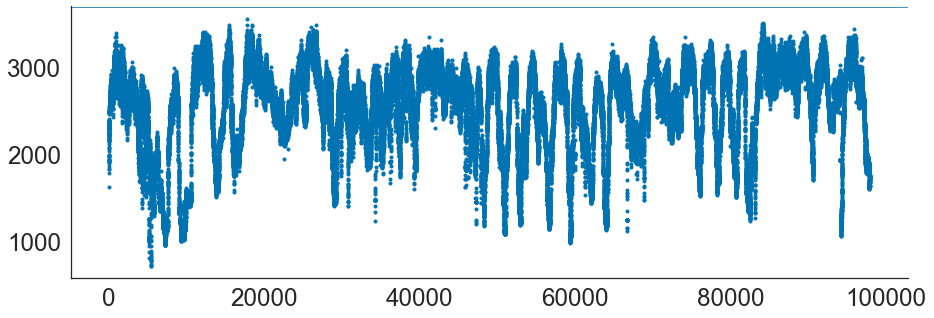

In [27]:

pupil = load_pupil(mouse, run_number)
run = load_run(mouse, run_number, pkl_path)

# Find out which recorded triggers were matched to the
# imaging frames. Assumes that imaging and pupil frames
# occur at roughly the same time
idx_imaged = np.isin(run.frame_clock, run.paqio_frames)
assert sum(idx_imaged) == run.flu.shape[1]
pupil = pupil[idx_imaged]

# Make this work with lots of mice
if run_number == 30:
    remove_threshold = 3700

pupil = mad_point_remover(pupil, remove_threshold, plot=True)
# Add an extra dimension so an array can be built in the same 
# was as flu
run.pupil = np.expand_dims(pupil, 0)

In [118]:
session = SessionLite(mouse, run_number, pkl_path, 'flu', pre_gap_seconds=0, post_gap_seconds=0)
times_use = session.filter_ps_time
flu = session.behaviour_trials

/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py
/home/jrowland/Documents/code/Vape
Now loading mouse RL117, run 30
/home/clean_python/code/Vape/run_pkls/RL117/run30.pkl
microcontroller trial starts occur on average nan ms from galvo trial starts
photo stim occurences: {0: 69, 1: 73, 2: 78}
Occurence table:
[[64.  5.]
 [58. 15.]
 [51. 27.]]
204 / 733 cells filtered
STIM RADIUS FOR TARGET REDUCED FIXED IN FUTURE
hfksldjfs
198
197
197 / 197 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]


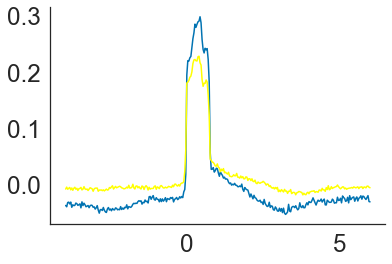

In [144]:
plt.plot(times_use, np.mean(session.behaviour_trials[:, session.outcome=='hit', :], (0,1)))
plt.plot(times_use, np.mean(session.behaviour_trials[:, session.outcome=='miss', :], (0,1)), color='yellow')

In [244]:
def get_percent_cells_responding(session, region):

    fdr_rate = 0.1

    flu = session.behaviour_trials
    times_use = session.filter_ps_time
    
    if region == 's1':
        flu = flu[session.s1_bool, :, :]
    elif region == 's2':
        flu = flu[session.s2_bool, :, :]
    
    percent_cells_responding = []

    for trial_idx in range(flu.shape[1]):

        # Haven't built this for 5 Hz data
        assert mouse not in ['J048', 'RL048']

        trial = flu[:, trial_idx, :]

        # 500 ms before the stim with a nice 
        # juicy buffer to the artifact
        pre_idx = np.where(times_use < -0.07)[0][-15:]  

        # You can dial this back closer to the artifact if you cut out 150
        post_idx = np.logical_and(times_use > 1, times_use <= 1.5)

        pre_array = trial[:, pre_idx]
        post_array = trial[:, post_idx]

        p_vals = [stats.wilcoxon(pre, post)[1] for pre, post in zip(pre_array, post_array)]
        p_vals = np.array(p_vals)

        sig_cells, correct_pval, _, _ = multitest.multipletests(p_vals, alpha=fdr_rate, method='fdr_bh',
                                                            is_sorted=False, returnsorted=False)

        percent_cells_responding.append(sum(sig_cells))

    percent_cells_responding = np.array(percent_cells_responding) / sum(session.s2_bool) * 100
    assert len(n_cells_responding) == flu.shape[1]
    
    return percent_cells_responding

Text(0, 0.5, 'S2 cells responding (%)')

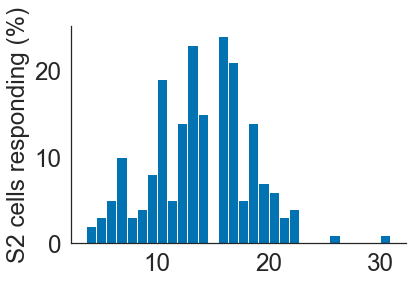

In [251]:
s2_responds = get_percent_cells_responding(session, 's2')
_ = plt.hist(s2_responds, 30)
plt.ylabel('S2 cells responding (%)')

Text(0.5, 0, 'Pupil area before trial\n(AU)')

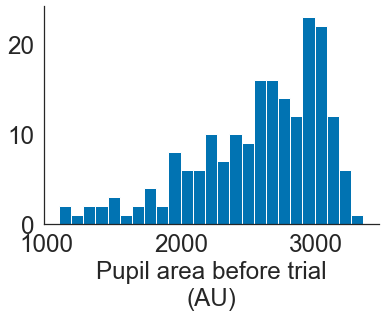

In [248]:
pupil_arr = build_flu_array_single(run, use_pupil=True, pre_frames=session.pre_frames,
                                   post_frames=session.post_frames)
pupil_arr = pupil_arr[:, session.nonnan_trials, :].squeeze()

pre_pupil = np.mean(pupil_arr[:, times_use<0], 1)
_ = plt.hist(pre_pupil, 25)
plt.xlabel('Pupil area before trial\n(AU)')

Text(0, 0.5, 'Pupil area before trial\n(AU)')

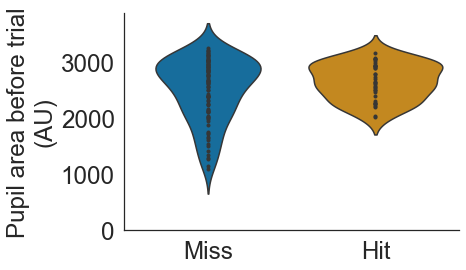

In [232]:
_ = plt.hist(pre_pupil[session.outcome=='miss'], 15, color='red')
_ = plt.hist(pre_pupil[session.outcome=='hit'], 15)

sns.violinplot(data=[pre_pupil[session.outcome=='miss'], pre_pupil[session.outcome=='hit']],
               orient='v', inner='point')
plt.xticks([0,1], ['Miss', 'Hit'])
plt.ylabel('Pupil area before trial\n(AU)')

Text(0, 0.5, 'S2 cells responding (%)')

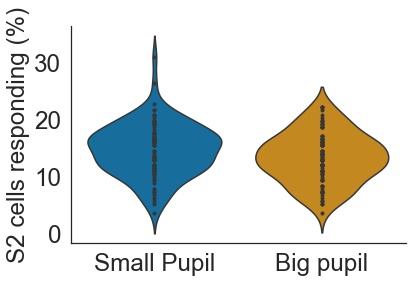

In [252]:
small = pre_pupil <= np.median(pre_pupil)
big = pre_pupil > np.median(pre_pupil)

sns.violinplot(data=[s2_responds[small], s2_responds[big]], orient='v', inner='point')
plt.xticks([0,1], ['Small Pupil', 'Big pupil'])
plt.ylabel('S2 cells responding (%)')

In [56]:
def lineplot_matrix(data, x_axis, color, label):

    df = pd.DataFrame(data).melt()
    df['time (seconds)'] = np.repeat(x_axis, data.shape[0])

    sns.lineplot(x='time (seconds)', y='value', data=df, color=color,
                label=label)
    

Text(0, 0.5, 'Pupil Area (AU)')

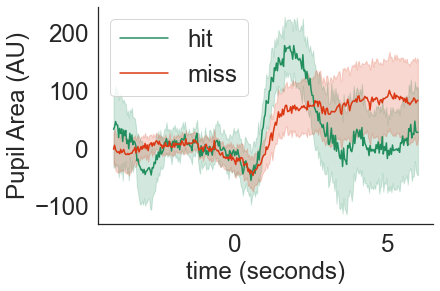

In [147]:
x_axis = session.filter_ps_time

# Baseline the pupil
baseline = np.mean(pupil_arr[:, :session.pre_frames], 1)
pupil_arr = np.subtract(pupil_arr.T, baseline).T

lineplot_matrix(data=pupil_arr[session.outcome=='hit'], x_axis=x_axis, color=COLORS[0], label='hit')
lineplot_matrix(data=pupil_arr[session.outcome=='miss'], x_axis=x_axis, color=COLORS[1], label='miss')
# lineplot_matrix(data=pupil_arr[session.outcome=='fp'], x_axis=x_axis, color='orange', label='fp')
# lineplot_matrix(data=pupil_arr[session.outcome=='cr'], x_axis=x_axis, color='pink', label='cr')
plt.ylabel('Pupil Area (AU)')

